# Google Playstore Apps Regression Problem

## Author - Keyuri Raodeo



# Dataset
The Google Play Store Apps dataset on Kaggle (https://www.kaggle.com/lava18/google-play-store-apps) contains information scraped from Google Play store. The information includes the app name, category, ratings, reviews, price, genre etc.

## Problem
The problem addressed in this project is to analyze the data to find how the different variables affect the ratings of the apps in order to predict the app ratings at the end. This is done by looking at the correlations of various variables with the app ratings and then, using a machine learning model to predict the app ratings.

In [58]:
# Import libraries
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [59]:
# Load dataset
current_dir = os.getcwd()
app_df = pd.read_csv(current_dir + "/googleplaystore.csv", sep=',', header=0)
app_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [60]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 592.9+ KB


## Data Cleaning

Looking at the data types, most variables are categorical and thus, need to be converted to numeric format.

In [61]:
## Step 1: Converting categorical variables into numeric variables/Dummy Variables - 'Price' & 'Reviews'
app_df['Price'] = [ re.sub("\$", "", x) if "$" in x else x for x in app_df['Price'] ]
num_columns = ['Reviews', 'Price']
app_df[num_columns] = app_df[num_columns].apply(pd.to_numeric, errors='coerce')

In [62]:
## 'Size' variable
def scaling(size):
    if 'M' in size:
        x = float(size[:-1])*1000000
        return(x)
    elif 'k' in size:
        x = float(size[:-1])*1000
        return(x)

app_df["Size"] = app_df["Size"].map(scaling)

In [63]:
## 'Installs' variable

app_df['Installs'] = [ x.replace('Free','0') for x in app_df['Installs']]
app_df['Installs'] = [x[:-1].replace(',','') if x != '0' else x for x in app_df['Installs']]
app_df['Installs'] = pd.to_numeric(app_df['Installs'])

In [64]:
## 'Type' variable
app_df['Type'] = app_df['Type'].str.replace('0', 'Free')
app_df['Type'] = app_df['Type'].str.replace('Free','0').replace('Paid', '1')
app_df['Type'] = pd.to_numeric(app_df['Type'])

In [65]:
## 'Content Rating' variable
CRating = app_df['Content Rating'].unique()
Dict = {}
for x in range(len(CRating)):
    Dict[CRating[x]] = x
app_df['Content_dummy'] = app_df['Content Rating'].map(Dict).astype(int)

In [66]:
## 'Genre' variable
genre = app_df['Genres'].unique()
Dict = {}
for i in range(len(genre)):
    Dict[genre[i]] = i
app_df['Genres_dummy'] = app_df['Genres'].map(Dict).astype(int)


Now that we have taken a converted most of the variable to numeric in the dataset, we need to find any nulls/outliers in the dataset.

In [67]:
## Step 2: Finding nulls in the dataset
null_columns=app_df.columns[app_df.isnull().any()]
app_df[null_columns].isnull().sum()

Rating            1474
Reviews              1
Size              1696
Type                 1
Price                1
Content Rating       1
Current Ver          8
Android Ver          3
dtype: int64

We will remove the rows containing null values in the dataset. However, since the number of nulls in the 'Rating' and 'Size' columns is far more, we will replace those with a 0, to differentiate it from other values.

In [68]:
# Remove rows with null values, except "Rating" and "Size" column
null_columns = app_df.columns[app_df.isna().any()].tolist()

for column in null_columns:
    if column != 'Rating' and column != 'Size':
        app_df = app_df[pd.notnull(app_df[column])]

# Replace nulls with mean in "Rating" and ""Mean column
HasNan = np.isnan(app_df.loc[:,'Rating'])
app_df.loc[HasNan, 'Rating'] =  round(np.nanmean(app_df.loc[:,'Rating']))
HasNan = np.isnan(app_df.loc[:,'Size'])
app_df.loc[HasNan, 'Size'] =  round(np.nanmean(app_df.loc[:,'Size']))

#Confirming if there are any missing values left in the dataframe
app_df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
Content_dummy     0
Genres_dummy      0
dtype: int64

Now that we have dealt with the null values, we will remove the redundant features in the dataset. The 'App' feature isn't relevant to the analysis, since we are focussing on the different genres and not individual apps. Also, the features 'Category' and 'Genres' are almost the same. Thus, we will drop the 'App' and 'Category' features. We will also drop the variables, 'Last Updated', 'Current Ver', 'Android Ver' since they aren't useful for this analysis.

In [69]:
## Data Cleaning - Step 3: Feature reduction
app_df = app_df.drop(columns = ['App','Category', 'Last Updated', 'Current Ver', 'Android Ver'])

Now that all the data is cleaned and ready to be explored, we will confirm if all the variables are as we want them to be.

In [70]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10829 entries, 0 to 10840
Data columns (total 10 columns):
Rating            10829 non-null float64
Reviews           10829 non-null float64
Size              10829 non-null float64
Installs          10829 non-null int64
Type              10829 non-null float64
Price             10829 non-null float64
Content Rating    10829 non-null object
Genres            10829 non-null object
Content_dummy     10829 non-null int32
Genres_dummy      10829 non-null int32
dtypes: float64(5), int32(2), int64(1), object(2)
memory usage: 761.4+ KB


Once that is confirmed, we will explore the data using summary statistics, frequency tables and data visualization.

## Data Exploration

In [71]:
# Summary Statistics
app_df.describe()

,Rating,Reviews,Size,Installs,Type,Price,Content_dummy,Genres_dummy
count,10829.000000,1.082900e+04,1.082900e+04,1.082900e+04,10829.000000,10829.000000,10829.00000,10829.000000
mean,4.165814,4.446018e+05,2.153496e+07,1.547990e+07,0.073599,1.028091,0.32810,50.466340
std,0.483521,2.929213e+06,2.075119e+07,8.507114e+07,0.261129,15.957778,0.76176,34.489296
min,1.000000,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.000000,3.800000e+01,5.900000e+06,5.000000e+03,0.000000,0.000000,0.00000,19.000000
50%,4.200000,2.100000e+03,1.800000e+07,1.000000e+05,0.000000,0.000000,0.00000,38.000000
75%,4.500000,5.481500e+04,2.600000e+07,5.000000e+06,0.000000,0.000000,0.00000,89.000000
max,5.000000,7.815831e+07,1.000000e+08,1.000000e+09,1.000000,400.000000,5.00000,119.000000


Notice the summary statistics is displayed for all the columns, since we have converted all variables to numeric.

In the following code, the data are grouped first by Genre and then by the ratings of app (1.0 to 5.0). This table gives us a feel for which genres only have apps with high ratings and which ones have apps with both low and high ratings, and how many of each. The groups with counts of zero do not display in the table. 

In [72]:
# Frequency tables with grouping

app_df['counts'] = 1
app_df[['counts', 'Rating', 'Genres']].groupby(['Genres', 'Rating']).agg('count')

counts
Genres                                Rating        
Action                                3.1          1
                                      3.2          1
                                      3.3          2
                                      3.4          3
                                      3.5          3
                                      3.6          3
                                      3.7          7
                                      3.8          8
                                      3.9         14
                                      4.0         27
                                      4.1         27
                                      4.2         46
                                      4.3         57
                                      4.4         56
                                      4.5         49
                                      4.6         40
                                      4.7         20
                                      5.0          1
Action;Action & Adventure             3.9          1
                                      4.0          1
                                      4.2          1
                                      4.3          9
                                      4.4          1
                                      4.5          3
                                      4.6          1
Adventure                             3.4          1
                                      3.5          2
                                      3.6          4
                                      3.7          1
                                      3.8          6
...                                              ...
Video Players & Editors               4.8          6
                                      4.9          1
Video Players & Editors;Creativity    4.1          2
Video Players & Editors;Music & Video 4.0          3
Weather                               3.3          1
                                      3.5          2
                                      3.6          1
                                      3.7          3
                                      3.8          5
                                      3.9          4
                                      4.0         10
                                      4.1          1
                                      4.2         15
                                      4.3          4
                                      4.4         14
                                      4.5         13
                                      4.6          3
                                      4.7          3
                                      4.8          3
Word                                  3.8          1
                                      3.9          3
                                      4.0          2
                                      4.2          4
                                      4.3          4
                                      4.4          2
                                      4.5          2
                                      4.6          1
                                      4.7          5
                                      4.8          4
                                      4.9          1

[1235 rows x 1 columns]

As can be seen in the frequency tables, some genres only have apps with high ratings, while some have apps with both high and low ratings. Although the frequency tables are informative, we will get a clear picture once we plot this data. Thus, we take the bar plot for Genres that appear more than 50 times in the dataset.

/home/keyuri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0.5, 1.0, 'Bar Plot of Genres')

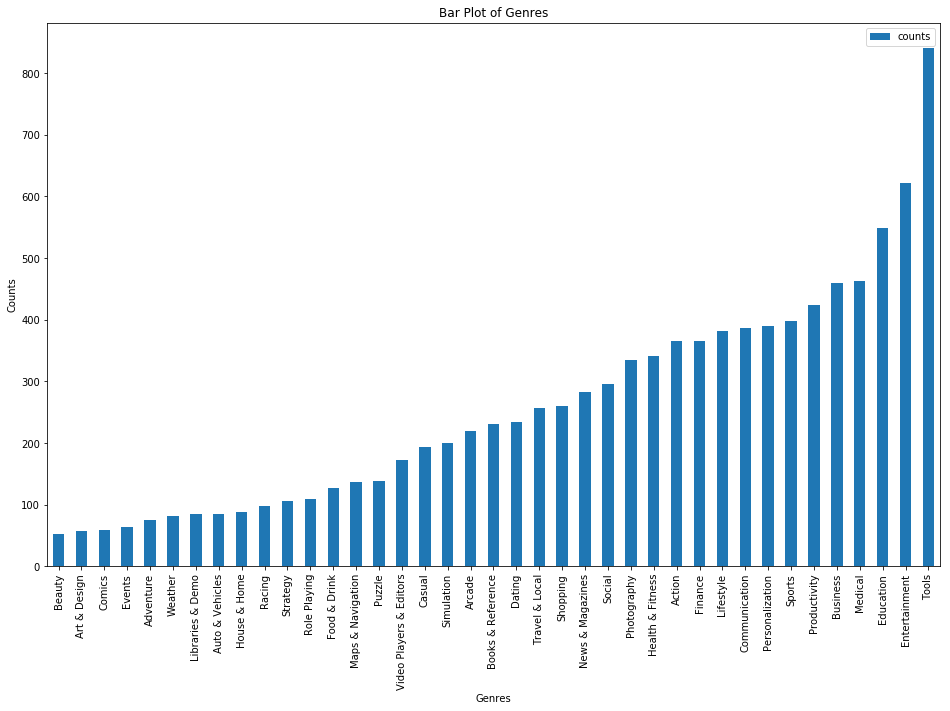

In [73]:
# Data Visualization
%matplotlib inline

high_count_genre = app_df[app_df.groupby('Genres')['Genres'].transform('size') > 50]
high_count_genre['counts']=1
ax = high_count_genre.loc[:, ['Genres', 'counts']].groupby(['Genres']).agg('count').sort_values('counts').plot.bar(figsize=(16,10))
ax.set_ylabel('Counts')
ax.set_title('Bar Plot of Genres')

The bar plot shows the counts of each genre. The top five genres are Tools, Entertainment, Education, Medical and Business. Let's look at the distribution of 'Ratings'.

Text(0.5, 1.0, 'Histogram of Ratings')

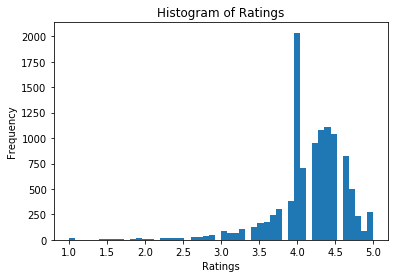

In [74]:
# Histogram of Ratings
app_df.loc[:,'Rating'].plot.hist(bins = 50)
plt.xlabel('Ratings')
plt.title("Histogram of Ratings")

The histogram of 'Rating' shows a left skewed normal distribution, which tells that there are far more apps with high rating than there are with low rating. But, more importantly, there are two interesting spikes around 4 and 4.5. Now, let's combine the two features to see what is the distribution of ratings for different genres using a heat map. Heat maps also bring clarity and solve any overplotting problem.

Text(0.5, 1.0, 'Genres of apps by ratings')

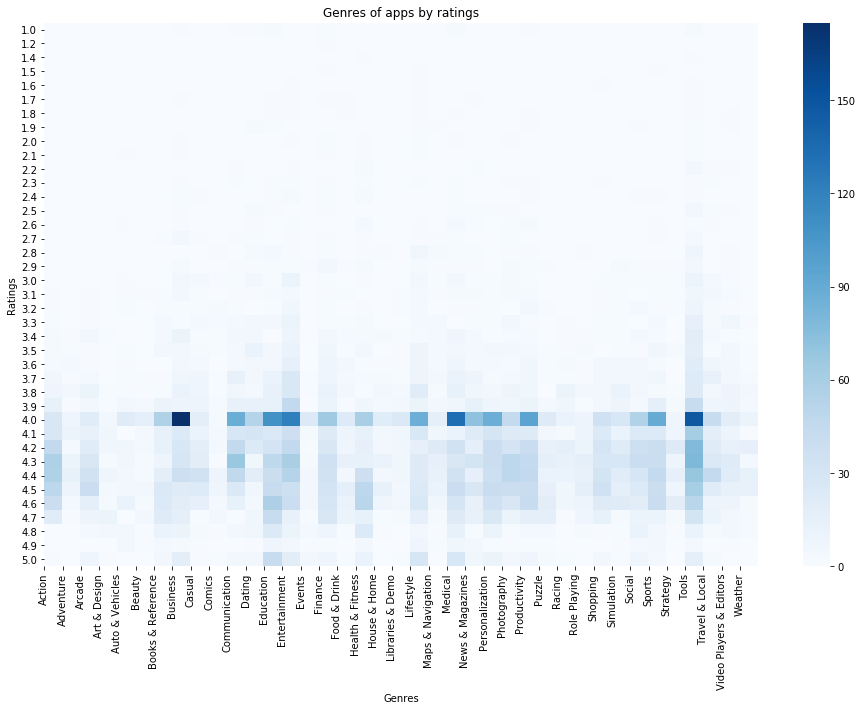

In [75]:
# Heat Map
genre = pd.crosstab(high_count_genre.loc[:, 'Rating'], high_count_genre.loc[:, 'Genres'])
ax = plt.figure(figsize=(16, 10)).gca() # define axis
sns.heatmap(genre, cmap="Blues")
ax.set_xticks(range(genre.shape[1]))
ax.set_xticklabels(genre.columns, rotation=90)
ax.set_xlabel('Genres')
ax.set_ylabel('Ratings')
ax.set_title('Genres of apps by ratings')

The heatmap confirms our findings from the histogram that most of the Genres have a high rating. However, it also shows that the most popular Genres like Business, Entertainment and Tools also have some lower ratings. 

Now, let's find out how the other variables affect app ratings.

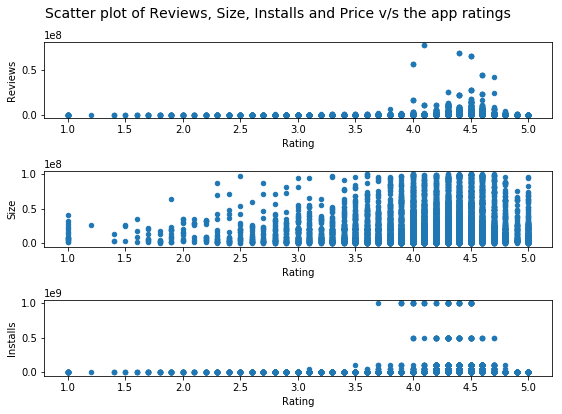

In [76]:
# Scatter plots of reviews, size and installs of apps with the ratings
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.suptitle('Scatter plot of Reviews, Size, Installs and Price v/s the app ratings', fontsize=14)
app_df.plot.scatter(x = 'Rating', y = 'Reviews', legend=False, ax=ax1, figsize=(8,6))
app_df.plot.scatter(x = 'Rating', y = 'Size', legend=False, ax=ax2, figsize=(8,6))
app_df.plot.scatter(x = 'Rating', y = 'Installs', legend=False, ax=ax3, figsize=(8,6))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

The scatter plots show the following observations:
1. Most apps have very few reviews. However, the apps having high number of reviews are apps with high ratings (between 4.0 and 5.0). This means that more the number of reviews, more will be the app ratings.
2. Surprisingly, most of the apps with greater sizes have high ratings, while apps with small sizes have both low as well as high ratings.
3. As expected, apps with very high installs are the apps with high ratings.

Finally, let's look at how the prices affect the ratings, for different categories of content rating.

/home/keyuri/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'App price v/s Ratings \n with content rating by color')

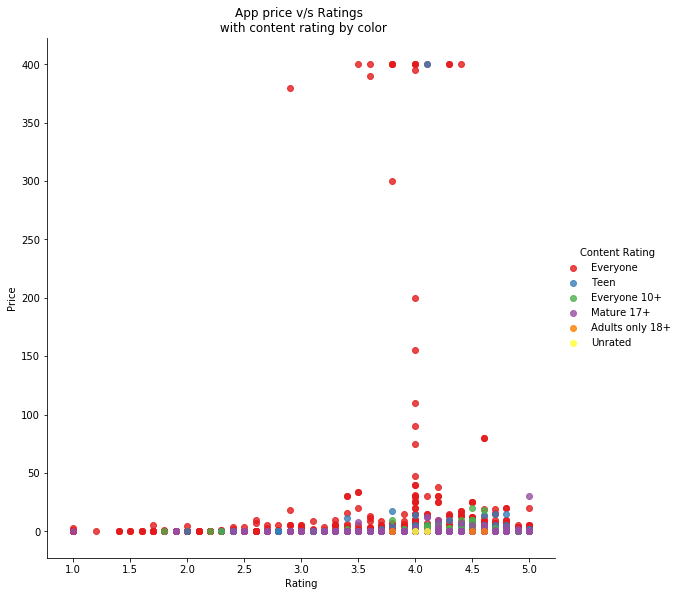

In [77]:
sns.lmplot(x = 'Rating', y = 'Price', 
           data = app_df, 
           hue = "Content Rating", 
           palette="Set1", 
           scatter_kws={'alpha':0.8},
           fit_reg = False,
           size=8, aspect=1)
plt.xlabel('Rating')
plt.ylabel('Price')
plt.title('App price v/s Ratings \n with content rating by color')

The plot shows that there are a lot more free apps (Price = 0) than paid apps (non-zero Price). However, most of the paid have high ratings (>3.5). An interesting thing to note is that there are more paid apps with a rating of ~4.0 than there are with a rating of 5.0. Additionally, most apps falls in the category of "Everyone" in Content Rating, while there are only a couple of unrated apps. Most adult apps (17+ or 18+) are either free or are available at a low cost.

## Statistical Analysis

Now that we have attained some information about the dataset, we will use hypothesis test to find out if the ratings for the two types of apps (free or paid) have significant difference. Our preliminary assumption is that since, free apps get downloaded more, they get more number of ratings and thus, they have more chances of getting higher ratings. Thus, the assumption is that the difference is significant and that it cannot be due to random variation alone. Here, the null hypothesis is that the difference in means of ratings between the two types of apps is due to random variation alone.

In [78]:
# Differences between the ratings conditioned by the a) types of apps (free/paid):

## Create a new dataframe for the hypothesis testing
rating_type_hypothesis = pd.DataFrame({'ratings': app_df['Rating'],
                                       'type': app_df['Type'],
                                       'content_rating': app_df['Content_dummy']})

## Create new variables containing ratings for each type of app
free = rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'type'] == 0, 'ratings']
paid = rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'type'] == 1, 'ratings']

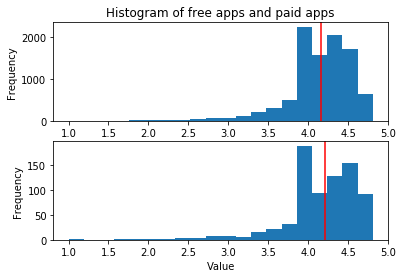

In [79]:
## Comparing the means of two normal distributions
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_pop(free, paid, ['free apps', 'paid apps'])  

The values of the distributions of these two populations overlap quite a bit and the means seem to be close. But since the range of values on X-axis is small, we need a t-test to determine if the difference of means is significant. A t-test is used to compare two means or proportions, when the population is normally distributed. 

Here, we use a two sided t-test, which means that for a significance level of $0.05$ ($alpha = 0.05$), a two-tailed test allots half of the alpha to testing the statistical significance in one direction and half of the alpha to testing statistical significance in the other direction. This means that $0.025$ is in each tail of the distribution of the test statistic.

In [80]:
## Two-sided t-test

def t_test(a, b, alpha, alternative='two-sided'):
   
    # difference of means
    diff = a.mean() - b.mean()

    # set-up the t-test b/w a and b (Welsch's)
    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    # compute the confidence intervals (alpha- cut-off)
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   
## 0.05 is the cut-off
test = t_test(free, paid, 0.05)
print(test)

DegFreedom    915.235178
Difference     -0.054103
Statistic      -3.041566
PValue          0.002359
Low95CI        -0.090399
High95CI       -0.017806
dtype: float64


Interpretation:

1. The t-statistic is large and the p-value is small.
2. The 95% confidence interval does not straddle 0.

Therefore, there is a high chance that the difference in means is not from random variation alone, but is statistically significant. Based on this statistic, our preliminary assumption seems to be right and we can reject the null hypothesis. Let's confirm this by plotting confidence indervals.

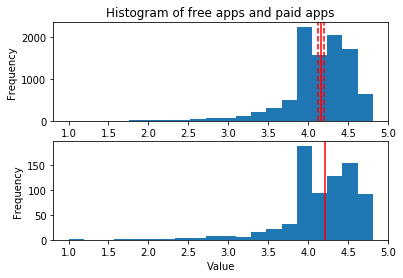

In [81]:
## Histograms with confidence intervals

def hist_mean_ci(vec, t_test, bins):
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols, nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
plot_t(free, paid, test, ['free apps', 'paid apps'])

Notice that the mean of the population in the lower plot is just outside the confidence interval of the difference of means of the populations. This confirms that the difference of means is significant and we can reject the null hypothesis that the difference in means is from random variation alone.

Now, in order to test the differences in means of ratings for different content ratings, we need an ANOVA test. An ANOVA test is used when means of more than two groups are to be compared. We know that, there are more apps that are for everyone and that, they have higher reviews. Here, our assumption is that the difference in means between the categories of content ratings is significant and that it cannot be due to random variation alone. Here, the null hypothesis is that the difference in means of ratings between the different categories of content ratings is due to random variation alone.

Text(0.5, 1.0, 'Box plot for everyone, teen, mature and above10')

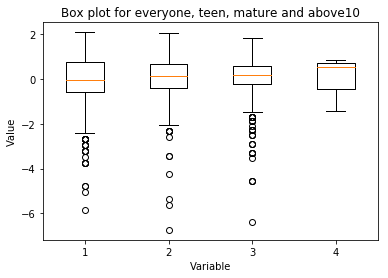

In [82]:
# ANOVA test to test the differences between the ratings conditioned by the content ratings:

everyone = scale(rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'content_rating'] == 1, 'ratings'])
teen = scale(rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'content_rating'] == 2, 'ratings'])
mature = scale(rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'content_rating'] == 3, 'ratings'])
above10 = scale(rating_type_hypothesis.loc[rating_type_hypothesis.loc[:, 'content_rating'] == 4, 'ratings'])

plt.boxplot([everyone, teen, mature, above10])
plt.ylabel('Value')
plt.xlabel('Variable')
plt.title('Box plot for everyone, teen, mature and above10')

As can be seen from the boxplot, there is some variation between the range of the four variables. But, we will calculate the f-statistic and p-value to test the significance of the variation in the distributions.

In [83]:
# Finding the statistics:
f_statistic, p_value = ss.f_oneway(everyone, teen, mature, above10)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 3.284813553926993e-29
P-value = 1.0


The F statistic is very small and the p-value is large. Thus, we cannot reject the null hypothesis that the four variables do not have a significant difference in means, as the probability of the differences arising from random chance is quite high. 

## Predictive Modeling

Now, we apply linear regression model to the data set and predict the ratings depending on features that affect the target variable ('Rating'). These features are 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating' and 'Genres'. But, before applying the model, the data will be standardized and normalized.

In [84]:
# Separate the features and labels
X = app_df[['Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content_dummy', 'Genres_dummy']]
y = app_df['Rating']

# Standardize data
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Normalize data
scaler = Normalizer().fit(X)
X = scaler.transform(X)

### Preliminary Model

[4.13916468 4.45631273 4.09552845 4.09116682 4.09843787]


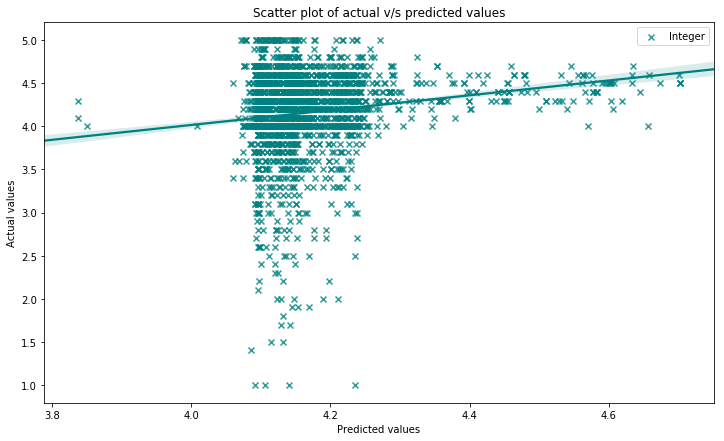

In [85]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Linear Regression to predict the ratings
linear_model = LinearRegression().fit(X_train, y_train)
test_pred = linear_model.predict(X_test)
print(test_pred[:5])

# Scatter plot of actual v/s predicted values
plt.figure(figsize=(12,7))
sns.regplot(test_pred,y_test,color='teal', label = 'Integer', marker = 'x')
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Scatter plot of actual v/s predicted values")
plt.legend()

The linear regression shows an interesting result. The first five predictions as well as the scatter plot shows that the predictions are mostly concentrated in $4.0$ to $4.3$ range. Also, most of the actual values overlap with these predictions.

In [86]:
print ("Mean of the predictions = ", test_pred.mean())
print ("Standard deviation of the predictions = ", test_pred.std())
print ("Mean of the actual values = ", y_test.mean())
print ("Standard deviation of the actual values = ", y_test.std())

Mean of the predictions =  4.167553021004127
Standard deviation of the predictions =  0.09145586301029755
Mean of the actual values =  4.160849492151431
Standard deviation of the actual values =  0.49243704510092734


In [87]:
train_pred = linear_model.predict(X_train)
print('Training Set:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, train_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, train_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, train_pred)))

Training Set:
Mean Absolute Error: 0.326229430557707
Mean Squared Error: 0.2232699143185599
Root Mean Squared Error: 0.4725144593751178


In [88]:
print('Testing Set:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))

Testing Set:
Mean Absolute Error: 0.3316531012403045
Mean Squared Error: 0.2363887299724263
Root Mean Squared Error: 0.48619824143288126


Thus, the mean of the predicted values is ~4.16, which is really close to the mean of the actual values. But, the standard deviation is around 0.09, which is pretty different from the standard deviation of the actual values.

We will use a gradient boosting algorithm, since boosting algorithms have been known to perform better than linear regression in many cases. We will also use a GridSearch to choose the best hyperparameters for the model.

### Improved model

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate, fit and predict. 
gbrt=GradientBoostingRegressor(random_state=42)

In [90]:
# Finding the best parameters using Grid Search CV
parameters = {"n_estimators":[200, 300]}
grid_gbrt = GridSearchCV(gbrt, parameters, cv=10).fit(X_train, y_train)
print ("Best parameters - ", grid_gbrt.best_params_)

Best parameters -  {'n_estimators': 200}


[4.1253838  4.41327207 4.07901382 4.13444979 4.06948798]


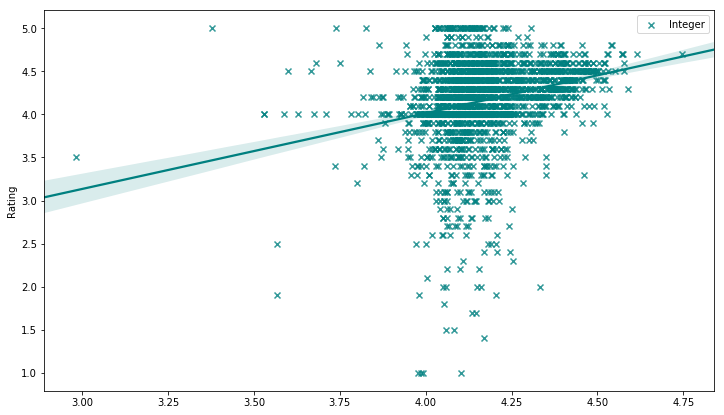

In [91]:
test_pred2 = grid_gbrt.predict(X_test)
print(test_pred2[:5])
plt.figure(figsize=(12,7))
sns.regplot(test_pred2,y_test,color='teal', label = 'Integer', marker = 'x')
plt.legend()

In [92]:
train_pred2 = grid_gbrt.predict(X_train)
print('Training Set:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, train_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, train_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, train_pred2)))

Training Set:
Mean Absolute Error: 0.2897598492273277
Mean Squared Error: 0.18311936224918232
Root Mean Squared Error: 0.42792448194650223


In [93]:
print('Testing Set:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, test_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, test_pred2)))

Testing Set:
Mean Absolute Error: 0.3178010001376978
Mean Squared Error: 0.22755003735445528
Root Mean Squared Error: 0.477022051224527


In [94]:
print ("Mean of the predictions = ", test_pred2.mean())
print ("Standard deviation of the predictions = ", test_pred2.std())
print ("Mean of the actual values = ", y_test.mean())
print ("Standard deviation of the actual values = ", y_test.std())

Mean of the predictions =  4.167203974216481
Standard deviation of the predictions =  0.1400400989609712
Mean of the actual values =  4.160849492151431
Standard deviation of the actual values =  0.49243704510092734


The standard deviation of the predicted values is slightly better than that we obtained using linear regression. But, the Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) values for the testing set are slightly different than those from the training set. The values we obtained using Linear Regression were pretty similar for testing and training sets.

Overall, the gradient boosting model performed similar to the linear regression.

## Conclusion
The goal of the project was to find the various relationships between the variables to find out how the variables affect the app ratings and then, predict the app ratings based on all these variables. 

After cleaning the data and converting all the necessary variables from categoric to numerical, the first part of the problem was addressed using data visualization techniques. Exploratory data analysis was performed on the dataset to find that the following observtions for high ratings:
1. Most genres of apps have a high rating
2. Apps having reviews (a non-zero number) are all high rating apps.
3. Apps with greater size always have high ratings
4. Apps with greater number of installs are high rating apps.
5. Paid apps have a high rating
6. Most of the adult only apps have a high rating.

Next, hypothesis tests were used to find out if the ratings for the types of apps (free and paid) and for the content ratings, have a significant difference in means. Since, the types of apps are only two, a two-sided t-test was used to test the null hypothesis that the difference in means of the ratings for the types of apps is due to random variation alone. However, an ANOVA test had to be used to test the null hypothesis for content ratings, since the categories were more than two. The results showed that the difference in means for the types of apps is significant and not from random variation alone, but the difference in means for the content ratings is from random variation alone.

Finally, a linear regression model was used to predict the app ratings after feature selection, normalizing and standardizing the variables. The means of the predicted and actual values matched well, however the standard deviation varied. The predicted values mostly contained a high rating, which is consistent with the observations from data visualization that most apps had high ratings. Then, we used a boosting algorithm to see if it improves the performance of the model. Although, the standard deviation obtained using gradient boosting was slightly better than that for linear regression, the overall values of the MSE, MAE and RMSE were almost the same.

In conclusion, it's hard to say which model performed better, since both the models performed in a similar way. It's better to choose the simpler model in such a case. Thus, I would go for linear regression instead of the gradient boosting model.